# Random Forest Model

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import random as rm
from itertools import cycle

## Load Data

In [2]:
def load_data_and_filter_ids(file_path):
    """
    Loads data from a CSV file, checks for NaN values in 'step' column grouped by 'series_id',
    and returns a list of 'series_id' values that do not contain NaNs.
    
    :param file_path: Path to the CSV file.
    :return: List of series IDs without NaN values in the 'step' column.
    """
    # Load data from CSV
    train_events = pd.read_csv(file_path)

    # Group by 'series_id' and check for NaN values in 'step' column
    series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())

    # Get list of series IDs that do not contain NaN values
    train_ids = series_has_nan[~series_has_nan].index.tolist()

    return train_ids

# Usage example:
file_path = "../data/train_events.csv"
train_ids = load_data_and_filter_ids(file_path)

## Feature Engineering

In [3]:
def get_multi_light_series(series_ids):
    """
    Fetches and processes a dataset for the given series IDs.

    :param series_ids: List of series IDs to fetch.
    :return: Processed DataFrame with added features.
    """
    print(f'Fetching series IDs: {series_ids} \n')
    file_path = "../data/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet"
    multi_series = pd.read_parquet(file_path, filters=[('series_id', 'in', series_ids)])
    multi_series = multi_series.astype({'series_id': 'category', 'step': 'int16', 'awake': 'int16'})
    multi_series = add_features(multi_series)

    return multi_series

def add_features(df):
    """
    Adds various features to the DataFrame.

    :param df: DataFrame to which features are added.
    :return: DataFrame with added features.
    """
    df = add_time_features(df)
    df = add_interaction_features(df)
    df = add_rolling_features(df, periods=6)  # 1/2 minute

    return df

def add_time_features(df):
    """ Adds time-related features to the DataFrame. """
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    return df

def add_interaction_features(df):
    """ Adds interaction features to the DataFrame. """
    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]
    return df

def add_rolling_features(df, periods):
    """ Adds rolling features to the DataFrame. """
    # Define operations to be applied
    operations = ["mean", "min", "max", "std"]
    columns = ["anglez", "enmo"]

    for column in columns:
        for operation in operations:
            df[f"{column}_{operation}"] = (
                df[column].rolling(periods, center=True).agg(operation).bfill().ffill().astype('float32')
            )

        # Differential features
        df[f"{column}_diff"] = (
            df.groupby('series_id', observed=True)[column].diff(periods=periods).bfill()
        )
        df[f"{column}_diff_rolling"] = (
            df[f"{column}_diff"].rolling(periods, center=True).mean().bfill().ffill().astype('float32')
        )

    return df


In [4]:
%time train_all = get_multi_light_series(train_ids[:35])
print(f'memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB')

Fetching series IDs: ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a', '3452b878e596', '349c5562ee2c', '3664fe9233f9', '483d6545417f', '55a47ff9dc8a', '5acc9d63b5fd', '5f94bb3e1bed', '655f19eabf1e', '67f5fc60e494', '72bbd1ac3edf', '76237b9406d5', '7822ee8fe3ec', '89bd631d1769', '8e32047cbc1f', '939932f1822d', '9ee455e4770d', 'a596ad0b82aa', 'a9a2f7fac455', 'a9e5f5314bcb', 'af91d9a50547', 'b364205aba43', 'c535634d7dcd', 'c6788e579967', 'c68260cc9e8f', 'ca730dbf521d', 'd150801f3145', 'd25e479ecbb7'] 

CPU times: total: 1min 31s
Wall time: 2min 11s
memory usage:  968.23 MB


In [5]:
train_all.head()

,series_id,step,timestamp,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_mean,...,anglez_max,anglez_std,anglez_diff,anglez_diff_rolling,enmo_mean,enmo_min,enmo_max,enmo_std,enmo_diff,enmo_diff_rolling
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.845301,0.0447,1,14,0,1.378785,-33.749619,...,-30.845301,1.463509,0.331902,0.331902,0.055533,0.0443,0.0768,0.013588,0.0626,0.0626
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.181801,0.0443,1,14,0,1.514254,-33.749619,...,-30.845301,1.463509,0.331902,0.331902,0.055533,0.0443,0.0768,0.013588,0.0626,0.0626
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.877102,0.0483,1,14,0,1.636264,-33.749619,...,-30.845301,1.463509,0.331902,0.331902,0.055533,0.0443,0.0768,0.013588,0.0626,0.0626
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.282101,0.0680,1,14,0,2.331183,-33.749619,...,-30.845301,1.463509,0.331902,0.331902,0.055533,0.0443,0.0768,0.013588,0.0626,0.0626
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.385799,0.0768,1,14,0,2.640830,-33.694302,...,-30.513399,1.595555,0.331902,0.331902,0.065967,0.0443,0.1073,0.023801,0.0626,0.0626


## Data Preprocessing

In [6]:
def scale_features_and_extract_target(df, feature_names, target_name):
    """
    Scales the features of the dataset and extracts the target variable.

    :param df: DataFrame containing the dataset.
    :param feature_names: List of feature names to be scaled.
    :param target_name: Name of the target variable.
    :return: Tuple of scaled features array and target variable array.
    """
    # Initialize the scaler
    scaler = StandardScaler()

    # Scale the features
    df_features_scaled = scaler.fit_transform(df[feature_names])

    # Extract the target variable
    df_target = df[target_name].values

    return df_features_scaled, df_target

In [7]:
# Example usage:
features = ["step", "hour", "dayofweek", "anglez_times_enmo",
            "anglez", "anglez_diff", "anglez_mean", "anglez_min", "anglez_max", "anglez_std", "anglez_diff_rolling",
            "enmo", "enmo_diff", "enmo_mean", "enmo_min", "enmo_max", "enmo_std", "enmo_diff_rolling"]
target = 'awake'

# Assuming 'train_all' is your DataFrame
df_train_X_scaled, df_train_y = scale_features_and_extract_target(train_all, features, target)

## Split Data

In [8]:
def prepare_data_and_split(df_features, df_target, split_ratio=0.8, convert_to_tensor=True):
    """
    Converts feature and target dataframes into PyTorch tensors and splits them into training and validation sets.

    :param df_features: DataFrame or array containing the feature data.
    :param df_target: DataFrame or array containing the target data.
    :param split_ratio: Float representing the proportion of the dataset to include in the train split.
    :param convert_to_tensor: Boolean 
    :return: Tuples of tensors (X_train, y_train), (X_val, y_val).
    """

    if convert_to_tensor:
        X = tensor(df_features, dtype=torch.float32)
        y = tensor(df_target, dtype=torch.long)
    else:
        X, y = df_features, df_target

    # Split the data
    split_index = int(len(X) * split_ratio)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return (X_train, y_train), (X_val, y_val)

In [9]:
(X_train, y_train), (X_val, y_val) = prepare_data_and_split(df_train_X_scaled, df_train_y)

# Checking the shapes
print("Train shapes (X, y):", X_train.shape, y_train.shape)
print("Validation shapes (X, y):", X_val.shape, y_val.shape)

Train shapes (X, y): torch.Size([10027296, 18]) torch.Size([10027296])
Validation shapes (X, y): torch.Size([2506824, 18]) torch.Size([2506824])


## Model

In [10]:
NUM_ITERATIONS = 4
RANDOM_STATE_MIN = 1
RANDOM_STATE_MAX = 500
N_ESTIMATORS_VALUES = [100, 200, 300]

rf_model = RandomForestClassifier()
rf_model

RandomForestClassifier()

## Training & Evaluation

In [11]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of the model.

    :param outputs: Model predictions.
    :param labels: Ground truth labels.
    :return: Accuracy as a float.
    """
    predictions = outputs.argmax(dim=1)
    correct = (predictions == labels)
    return correct.float().mean()

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a confusion matrix.

    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param class_names: List of class labels.
    """
    # Generate confusion matrix using sklearn
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    total = cm.sum()
    tn_percentage = (cm[0, 0] / total) * 100
    fp_percentage = (cm[0, 1] / total) * 100
    fn_percentage = (cm[1, 0] / total) * 100
    tp_percentage = (cm[1, 1] / total) * 100

    tn_text = f"{cm[0, 0]} ({tn_percentage:.2f}%)"
    fp_text = f"{cm[0, 1]} ({fp_percentage:.2f}%)"
    fn_text = f"{cm[1, 0]} ({fn_percentage:.2f}%)"
    tp_text = f"{cm[1, 1]} ({tp_percentage:.2f}%)"

    # Print confusion matrix as a table with percentages
    print(f"\nConfusion Matrix:")
    print(f"{'':<20} {'Predicted Negative':<20} {'Predicted Positive':<20}")
    print(f"{'Actual Negative':<20} {tn_text:<20} {fp_text:<20}")
    print(f"{'Actual Positive':<20} {fn_text:<20} {tp_text:<20}")

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', xticklabels=class_names, yticklabels=class_names, cbar=False) 

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [12]:
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators_value, classes):
    """Trains and evaluates the performance of a random forest model"""
    rf_model = RandomForestClassifier(n_estimators=n_estimators_value,min_samples_leaf=300,random_state=42,n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_prob = rf_model.predict_proba(X_test)[:,1]
    print("""

    """)

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes)

    # Calculate and print evaluation scores
    accuracy_value = accuracy_score(y_test, y_pred)
    recall_value = recall_score(y_test, y_pred)
    specificity_value = specificity_score(y_test, y_pred)
    avg_precision_value = average_precision_score(y_test, y_prob)

    print("Classification Report:")
    print(f'Accuracy: {accuracy_value:.2f}')
    print(f'Recall: {recall_value:.2f}')
    print(f'Specificity: {specificity_value:.2f}')
    print(f'Average Precision Score: {avg_precision_value:.2f}')



    partial_eval = 0.4 * specificity_value + 0.3 * recall_value + 0.3 * avg_precision_value
    print(f'Partial evaluation: {partial_eval:.2f}')
    print("\n\n")

    
    return accuracy_value, recall_value, specificity_value, avg_precision_value, partial_eval

In [13]:
def main():
    random_state_value = None
    results = []
    labels = ["Class 0", "Class 1"]

    for i in range(1, NUM_ITERATIONS + 1):
        print(f'Iteration {i}')
        if (i - 1) % len(N_ESTIMATORS_VALUES) == 0:
            random_state_value = rm.randint(RANDOM_STATE_MIN, RANDOM_STATE_MAX)
            print("Random State:", random_state_value)
            n_estimators_value = N_ESTIMATORS_VALUES[0]
        else:
            n_estimators_value = N_ESTIMATORS_VALUES[(i - 1) % len(N_ESTIMATORS_VALUES)]

        print("N estimators:", n_estimators_value)

        iteration_results = train_random_forest(X_train, y_train, X_val, y_val, n_estimators_value, labels)
        results.append(iteration_results)

    avg_results = tuple(map(lambda x: sum(x) / len(results), zip(*results)))
    print("\nClassification Report:")
    print(f'Accuracy: {avg_results[0]:.2f}')
    print(f'Recall: {avg_results[1]:.2f}')
    print(f'Specificity: {avg_results[2]:.2f}')
    print(f'Average Precision Score: {avg_results[3]:.2f}')


    final_eval = 0.4 * avg_results[2] + 0.3 * avg_results[1] + 0.3 * avg_results[3]
    print(f'Final Evaluation: {final_eval:.2f}')

## Predictions

Iteration 1
Random State: 191
N estimators: 100


    

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      786677 (31.38%)      56959 (2.27%)       
Actual Positive      70514 (2.81%)        1592674 (63.53%)    


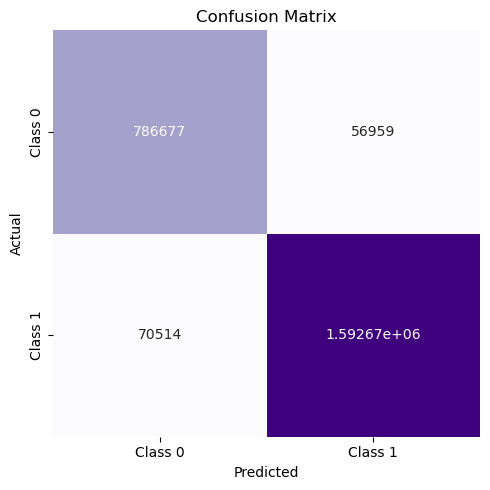

Classification Report:
Accuracy: 0.95
Recall: 0.96
Specificity: 0.93
Average Precision Score: 0.99
Partial evaluation: 0.96



Iteration 2
N estimators: 200


    

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      786757 (31.38%)      56879 (2.27%)       
Actual Positive      70113 (2.80%)        1593075 (63.55%)    


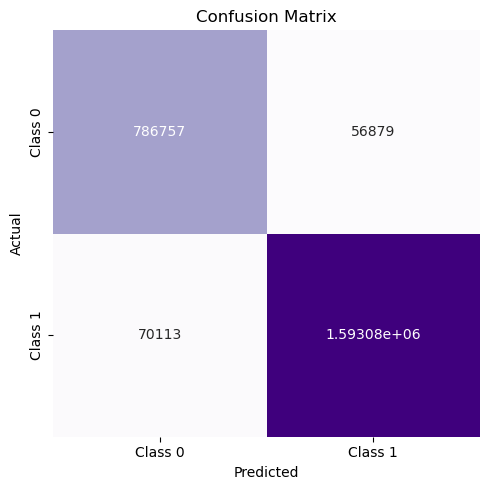

Classification Report:
Accuracy: 0.95
Recall: 0.96
Specificity: 0.93
Average Precision Score: 0.99
Partial evaluation: 0.96



Iteration 3
N estimators: 300


    

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      786701 (31.38%)      56935 (2.27%)       
Actual Positive      70637 (2.82%)        1592551 (63.53%)    


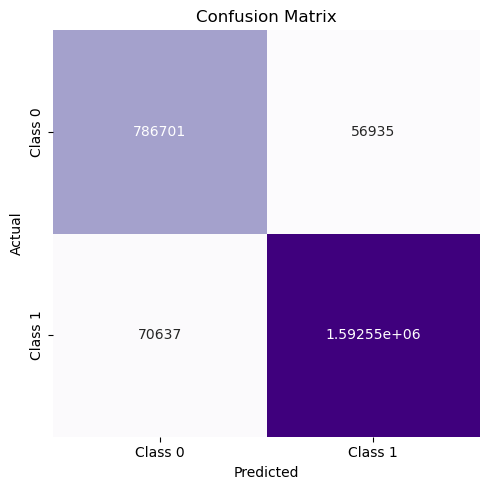

Classification Report:
Accuracy: 0.95
Recall: 0.96
Specificity: 0.93
Average Precision Score: 0.99
Partial evaluation: 0.96



Iteration 4
Random State: 285
N estimators: 100


    

Confusion Matrix:
                     Predicted Negative   Predicted Positive  
Actual Negative      786677 (31.38%)      56959 (2.27%)       
Actual Positive      70514 (2.81%)        1592674 (63.53%)    


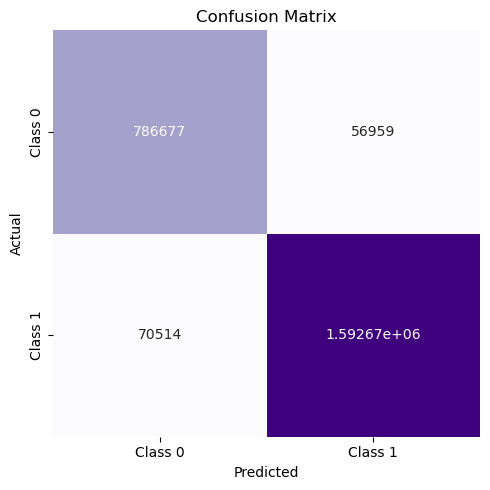

Classification Report:
Accuracy: 0.95
Recall: 0.96
Specificity: 0.93
Average Precision Score: 0.99
Partial evaluation: 0.96




Classification Report:
Accuracy: 0.95
Recall: 0.96
Specificity: 0.93
Average Precision Score: 0.99
Final Evaluation: 0.96


In [14]:
if __name__ == "__main__":
    main()